# Data Preparation

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import  mean_squared_error , mean_absolute_error , mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler , PolynomialFeatures
import math
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

pl_data = pd.read_csv('./data/training_data_pipelines.csv' ,sep=';' )
test_pl_data = pd.read_csv('./data/testing_data_pipelines.csv' ,sep=';' )

In [2]:
pl_data

,Q,pipeline,cpu_cost,io_cost,mem_cost,dop_pl,power,time,energy,governor,frequency,db_name,dop_q,HT: Disabled,C-states: Enabled,TurboBoost: Disabled,PC: i7
0,Q1,PL1,6577804.30,13445055.0,0.0,0.0,45.823890,108.183241,4957.376926,userspace,3400000,tpch_sf30,0,HT: Disabled,C-states: Enabled,TurboBoost: Disabled,PC: i7
1,Q1,PL2,1124955.80,1671781.0,0.0,0.0,47.396818,10.725339,508.346943,userspace,3400000,tpch_sf30,0,HT: Disabled,C-states: Enabled,TurboBoost: Disabled,PC: i7
2,Q1,PL1,6577804.30,13444895.0,160.0,0.0,42.640875,118.666060,5060.024631,userspace,3000000,tpch_sf30,0,HT: Disabled,C-states: Enabled,TurboBoost: Disabled,PC: i7
3,Q1,PL2,1124955.80,1671717.0,64.0,0.0,43.162714,13.880640,599.126098,userspace,3000000,tpch_sf30,0,HT: Disabled,C-states: Enabled,TurboBoost: Disabled,PC: i7
4,Q1,PL1,6577804.30,13444735.0,320.0,0.0,40.652008,129.509526,5264.822247,userspace,2700000,tpch_sf30,0,HT: Disabled,C-states: Enabled,TurboBoost: Disabled,PC: i7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,Q69,PL1,1.06,6728253.0,22299.0,0.0,36.695500,1.159333,42.542304,userspace,800000,tpch_sf50,4,HT: Disabled,C-states: Enabled,TurboBoost: Disabled,PC: i7
13124,Q69,PL2,0.06,2242751.0,7433.0,4.0,36.695500,0.000124,0.004550,userspace,800000,tpch_sf50,4,HT: Disabled,C-states: Enabled,TurboBoost: Disabled,PC: i7
13125,Q69,PL3,984244.72,5785685.0,19202.0,4.0,37.873383,58.415605,2212.396601,userspace,800000,tpch_sf50,4,HT: Disabled,C-states: Enabled,TurboBoost: Disabled,PC: i7
13126,Q69,PL4,126576.30,582412.0,8746.0,4.0,36.019750,3.620635,130.414368,userspace,800000,tpch_sf50,4,HT: Disabled,C-states: Enabled,TurboBoost: Disabled,PC: i7


- Cleaning the data.
- adding 1 to the degree of parallelism 

In [3]:
pl = pl_data.drop(['governor','HT: Disabled','C-states: Enabled','TurboBoost: Disabled','PC: i7'], inplace=False, axis=1)
pl_test = test_pl_data.drop(['governor','HT: Disabled','C-states: Enabled','TurboBoost: Disabled','PC: i7'], inplace=False, axis=1)
pl['dop_q'] = pl['dop_q'] + 1
pl_test['dop_q'] = pl_test['dop_q'] + 1
pl['dop_pl'] = pl['dop_pl'] + 1
pl_test['dop_pl'] = pl_test['dop_pl'] + 1
pl

,Q,pipeline,cpu_cost,io_cost,mem_cost,dop_pl,power,time,energy,frequency,db_name,dop_q
0,Q1,PL1,6577804.30,13445055.0,0.0,1.0,45.823890,108.183241,4957.376926,3400000,tpch_sf30,1
1,Q1,PL2,1124955.80,1671781.0,0.0,1.0,47.396818,10.725339,508.346943,3400000,tpch_sf30,1
2,Q1,PL1,6577804.30,13444895.0,160.0,1.0,42.640875,118.666060,5060.024631,3000000,tpch_sf30,1
3,Q1,PL2,1124955.80,1671717.0,64.0,1.0,43.162714,13.880640,599.126098,3000000,tpch_sf30,1
4,Q1,PL1,6577804.30,13444735.0,320.0,1.0,40.652008,129.509526,5264.822247,2700000,tpch_sf30,1
...,...,...,...,...,...,...,...,...,...,...,...,...
13123,Q69,PL1,1.06,6728253.0,22299.0,1.0,36.695500,1.159333,42.542304,800000,tpch_sf50,5
13124,Q69,PL2,0.06,2242751.0,7433.0,5.0,36.695500,0.000124,0.004550,800000,tpch_sf50,5
13125,Q69,PL3,984244.72,5785685.0,19202.0,5.0,37.873383,58.415605,2212.396601,800000,tpch_sf50,5
13126,Q69,PL4,126576.30,582412.0,8746.0,5.0,36.019750,3.620635,130.414368,800000,tpch_sf50,5


In [4]:
pl_test.db_name.unique()

array(['tpcds_sf50'], dtype=object)

- adding the scale factor feature from db_name

In [5]:


pl['db_name'] = pl['db_name'].replace(['tpch_sf50'], 50)
pl['db_name'] = pl['db_name'].replace(['tpch_sf10'], 10)
pl['db_name'] = pl['db_name'].replace(['tpch_sf30'], 30)

pl_test['db_name'] = pl_test['db_name'].replace(['tpcds_sf50'], 50)



In [6]:
pl

,Q,pipeline,cpu_cost,io_cost,mem_cost,dop_pl,power,time,energy,frequency,db_name,dop_q
0,Q1,PL1,6577804.30,13445055.0,0.0,1.0,45.823890,108.183241,4957.376926,3400000,30,1
1,Q1,PL2,1124955.80,1671781.0,0.0,1.0,47.396818,10.725339,508.346943,3400000,30,1
2,Q1,PL1,6577804.30,13444895.0,160.0,1.0,42.640875,118.666060,5060.024631,3000000,30,1
3,Q1,PL2,1124955.80,1671717.0,64.0,1.0,43.162714,13.880640,599.126098,3000000,30,1
4,Q1,PL1,6577804.30,13444735.0,320.0,1.0,40.652008,129.509526,5264.822247,2700000,30,1
...,...,...,...,...,...,...,...,...,...,...,...,...
13123,Q69,PL1,1.06,6728253.0,22299.0,1.0,36.695500,1.159333,42.542304,800000,50,5
13124,Q69,PL2,0.06,2242751.0,7433.0,5.0,36.695500,0.000124,0.004550,800000,50,5
13125,Q69,PL3,984244.72,5785685.0,19202.0,5.0,37.873383,58.415605,2212.396601,800000,50,5
13126,Q69,PL4,126576.30,582412.0,8746.0,5.0,36.019750,3.620635,130.414368,800000,50,5




*   Turning the data into an operatot based Data



In [7]:
obm = pl_data.groupby(['Q', 'frequency','db_name','dop_q']).agg({'cpu_cost':'sum','io_cost':'sum','mem_cost':'sum','power':'mean','time':'sum','energy':'sum'})   

In [8]:
obm

cpu_cost     io_cost  mem_cost      power  \
Q  frequency db_name   dop_q                                                
Q1 800000    tpch_sf10 0      4120605.58   5913014.0    1568.0  34.175525   
                       2      2275057.64  10169850.0   10864.0  34.973158   
                       4      1845717.27  10159482.0   24896.0  35.329217   
             tpch_sf30 0      7702760.10  15115268.0    1568.0  35.304098   
                       2      4992709.65  25219453.0   10864.0  35.284884   
...                                  ...         ...       ...        ...   
Q9 3400000   tpch_sf30 2      3921513.32  30997175.0  104936.0  44.784420   
                       4      3883152.03  31172873.0  105143.0  49.004159   
             tpch_sf50 0      6693778.36  32159661.0   73750.0  43.106363   
                       2      6473996.27  48209999.0  105319.0  46.524270   
                       4      6434676.93  48383652.0  105462.0  50.112061   

                                    time        energy  
Q  frequency db_name   dop_q                            
Q1 800000    tpch_sf10 0      222.955604   7615.165005  
                       2      103.389149   3750.426459  
                       4       84.357679   3127.275856  
             tpch_sf30 0      283.583761  10000.472460  
                       2      132.233541   4921.347300  
...                                  ...           ...  
Q9 3400000   tpch_sf30 2       45.843774   2365.852650  
                       4       46.246768   2499.240081  
             tpch_sf50 0       81.159479   3982.120529  
                       2       50.596098   2852.003210  
                       4       53.495765   3013.414837  

[4872 rows x 6 columns]

In [9]:
obm.head()

cpu_cost     io_cost  mem_cost      power  \
Q  frequency db_name   dop_q                                                
Q1 800000    tpch_sf10 0      4120605.58   5913014.0    1568.0  34.175525   
                       2      2275057.64  10169850.0   10864.0  34.973158   
                       4      1845717.27  10159482.0   24896.0  35.329217   
             tpch_sf30 0      7702760.10  15115268.0    1568.0  35.304098   
                       2      4992709.65  25219453.0   10864.0  35.284884   

                                    time        energy  
Q  frequency db_name   dop_q                            
Q1 800000    tpch_sf10 0      222.955604   7615.165005  
                       2      103.389149   3750.426459  
                       4       84.357679   3127.275856  
             tpch_sf30 0      283.583761  10000.472460  
                       2      132.233541   4921.347300

# Modeling : Testing the different features 

## Polynomial regression for **PBM**

In [10]:
pl.db_name.unique()

array([30, 10, 50], dtype=int64)

In [11]:
train_x_values  = pl[['cpu_cost' , 'io_cost' , 'mem_cost', 'dop_pl','frequency','db_name']].values
test_x_values = pl_test[['cpu_cost' , 'io_cost' , 'mem_cost', 'dop_pl','frequency','db_name']].values

train_y = pl['power'].values
test_y = pl_test['power'].values

scaler = StandardScaler().fit(train_x_values)


In [12]:
train_x_scaled = scaler.transform(train_x_values)
test_x_scaled = scaler.transform(test_x_values)

In [13]:
poly_model = PolynomialFeatures(degree=2)
poly_x_train = poly_model.fit_transform(train_x_scaled)
poly_x_test = poly_model.fit_transform(test_x_scaled)



In [14]:
regression_model = LinearRegression()
regression_model.fit(poly_x_train,train_y)




LinearRegression()

In [15]:

pred_y = regression_model.predict(poly_x_train)
regression_model.coef_

array([ 4.56728691e-16,  6.18177929e+00, -2.63119363e+00, -7.16563361e-01,
        3.88577039e+00,  4.07627392e+00, -4.47408578e-01, -1.69794061e-01,
       -4.00925074e-02, -5.05213933e-01,  1.50045520e+00,  8.54891283e-01,
       -2.12698697e+00,  1.52118064e-01, -6.52720912e-03, -1.40198344e+00,
       -7.37221201e-01,  7.40689185e-01,  1.95248872e-01,  1.08593384e-01,
        1.83566447e-01, -5.58768355e-01, -1.13008970e+00,  1.41866729e+00,
        1.29848086e-01,  9.80417621e-01,  3.88129002e-02,  1.62269869e-01])

### PR Evaluation

In [16]:
mean_absolute_percentage_error(train_y,pred_y)

0.10221322880331973

MSE

In [17]:

pred_y = regression_model.predict(poly_x_test)
mean_squared_error(test_y,pred_y, squared=False)

2262.7791650065546

RMSE

In [18]:
math.sqrt(mean_squared_error(test_y,pred_y, squared=False))

47.5686784029844

 MAE

In [19]:
mean_absolute_error(test_y,pred_y)


381.77275654765776

MAPE

In [20]:
mean_absolute_percentage_error(test_y,pred_y)

7.371598874391049

## Random forest regression for **PBM**

In [21]:
from sklearn.ensemble import RandomForestRegressor

In [22]:
rfr = RandomForestRegressor(n_estimators = 100, random_state = 0)

rfr.fit(train_x_scaled,train_y)

RandomForestRegressor(random_state=0)

### evaluation

In [23]:
pred_y = rfr.predict(train_x_scaled)
mean_absolute_percentage_error(train_y,pred_y)

0.022505329322795187

#### MAPE

In [24]:
pred_y = rfr.predict(test_x_values)
mean_absolute_percentage_error(test_y,pred_y)

0.20706075778595592

In [25]:
mean_squared_error(test_y,pred_y, squared=False)

11.818586063818493

In [26]:
math.sqrt(mean_squared_error(test_y,pred_y, squared=False))

3.4378170492070246

In [27]:
mean_absolute_error(test_y,pred_y)


9.849156889994637

## SVM for **PBM**

In [28]:
from sklearn import svm
from sklearn.metrics import accuracy_score

svr = svm.SVR(kernel = 'linear',  degree=1)
svr.fit(train_x_scaled,train_y)



SVR(degree=1, kernel='linear')

### evaluation

In [29]:
pred_y = svr.predict(train_x_scaled)
mean_absolute_percentage_error(train_y,pred_y)


0.11818319427564268

In [30]:
pred_y = svr.predict(test_x_scaled)
mean_absolute_percentage_error(test_y,pred_y)

0.19083330652914865

In [31]:
mean_squared_error(test_y,pred_y, squared=False)

11.244372712564655

In [32]:
math.sqrt(mean_squared_error(test_y,pred_y, squared=False))

3.353262994840198

In [33]:
mean_absolute_error(test_y,pred_y)


9.848865571380223

## Pipeline based model comparaison

In [34]:
train_pred = svr.predict(train_x_scaled)

In [35]:
pl_data.head()

,Q,pipeline,cpu_cost,io_cost,mem_cost,dop_pl,power,time,energy,governor,frequency,db_name,dop_q,HT: Disabled,C-states: Enabled,TurboBoost: Disabled,PC: i7
0,Q1,PL1,6577804.3,13445055.0,0.0,0.0,45.823890,108.183241,4957.376926,userspace,3400000,tpch_sf30,0,HT: Disabled,C-states: Enabled,TurboBoost: Disabled,PC: i7
1,Q1,PL2,1124955.8,1671781.0,0.0,0.0,47.396818,10.725339,508.346943,userspace,3400000,tpch_sf30,0,HT: Disabled,C-states: Enabled,TurboBoost: Disabled,PC: i7
2,Q1,PL1,6577804.3,13444895.0,160.0,0.0,42.640875,118.666060,5060.024631,userspace,3000000,tpch_sf30,0,HT: Disabled,C-states: Enabled,TurboBoost: Disabled,PC: i7
3,Q1,PL2,1124955.8,1671717.0,64.0,0.0,43.162714,13.880640,599.126098,userspace,3000000,tpch_sf30,0,HT: Disabled,C-states: Enabled,TurboBoost: Disabled,PC: i7
4,Q1,PL1,6577804.3,13444735.0,320.0,0.0,40.652008,129.509526,5264.822247,userspace,2700000,tpch_sf30,0,HT: Disabled,C-states: Enabled,TurboBoost: Disabled,PC: i7


In [36]:
pipeline = pl
pipeline_test = pl_test

pipeline['predict power'] = train_pred
pipeline.head()

,Q,pipeline,cpu_cost,io_cost,mem_cost,dop_pl,power,time,energy,frequency,db_name,dop_q,predict power
0,Q1,PL1,6577804.3,13445055.0,0.0,1.0,45.823890,108.183241,4957.376926,3400000,30,1,47.758231
1,Q1,PL2,1124955.8,1671781.0,0.0,1.0,47.396818,10.725339,508.346943,3400000,30,1,44.895434
2,Q1,PL1,6577804.3,13444895.0,160.0,1.0,42.640875,118.666060,5060.024631,3000000,30,1,45.744111
3,Q1,PL2,1124955.8,1671717.0,64.0,1.0,43.162714,13.880640,599.126098,3000000,30,1,42.881226
4,Q1,PL1,6577804.3,13444735.0,320.0,1.0,40.652008,129.509526,5264.822247,2700000,30,1,44.233558


In [37]:
test_pred = svr.predict(test_x_scaled)
pipeline_test['predict power'] = test_pred

In [38]:
query = pipeline.groupby(['Q', 'frequency','db_name','dop_q']).agg({'cpu_cost':'sum','io_cost':'sum','mem_cost':'sum','power':'mean','time':'sum','energy':'sum','predict power':'mean'})   


query_test = pipeline_test.groupby(['Q', 'frequency','db_name','dop_q']).agg({'cpu_cost':'sum','io_cost':'sum','mem_cost':'sum','power':'mean','time':'sum','energy':'sum','predict power':'mean'})  

In [39]:
query_test

cpu_cost    io_cost    mem_cost      power  \
Q   frequency db_name dop_q                                                
Q10 800000    50      1       22352.12        0.0    327119.0  42.069778   
                      3       21249.63        0.0    443191.0  41.947500   
                      5       20995.79        0.0    386078.0  43.745000   
    2100000   50      1       22352.12        0.0    327119.0  42.085000   
                      3       21249.63        0.0    443191.0  41.820000   
...                                ...        ...         ...        ...   
Q84 2100000   50      3      160077.34  6105429.0  10295218.0  50.771583   
                      5      153619.34  6091391.0  10309570.0  48.469491   
    3400000   50      1      182678.62  4637755.0   7721228.0  51.114939   
                      3      160077.34  6733157.0   9667490.0  58.042317   
                      5      153619.34  6703293.0   9697632.0  56.404586   

                                  time       energy  predict power  
Q   frequency db_name dop_q                                         
Q10 800000    50      1       1.015118    42.746629      31.193292  
                      3       0.474873    19.919735      35.209371  
                      5       0.390372    17.076823      35.194733  
    2100000   50      1       0.413096    17.385145      37.739658  
                      3       0.195814     8.188941      41.755736  
...                                ...          ...            ...  
Q84 2100000   50      3      36.645826  1942.315237      42.410115  
                      5      27.086951  1467.318888      45.402110  
    3400000   50      1      80.223375  4348.754140      45.534954  
                      3      38.626416  2359.098527      48.812438  
                      5      28.362208  1843.836847      51.808057  

[140 rows x 7 columns]

PBM acuracy for query

In [40]:
mean_absolute_percentage_error(query['power'],query['predict power'])

0.07117046689696033

In [41]:
mean_absolute_percentage_error(query_test['power'],query_test['predict power'])

0.18274214503288283

## Operation based model 

In [42]:
query = pipeline.groupby(['Q', 'frequency','db_name','dop_q']).agg({'cpu_cost':'sum','io_cost':'sum','mem_cost':'sum','power':'mean','time':'sum','energy':'sum','predict power':'mean'})  
query_test = pipeline_test.groupby(['Q', 'frequency','db_name','dop_q']).agg({'cpu_cost':'sum','io_cost':'sum','mem_cost':'sum','power':'mean','time':'sum','energy':'sum','predict power':'mean'})  

In [43]:
arra = query.index.get_level_values(1)
arra

Int64Index([ 800000,  800000,  800000,  800000,  800000,  800000,  800000,
             800000,  800000, 1200000,
            ...
            3000000, 3400000, 3400000, 3400000, 3400000, 3400000, 3400000,
            3400000, 3400000, 3400000],
           dtype='int64', name='frequency', length=4872)

In [44]:
df = query[['cpu_cost' , 'io_cost' , 'mem_cost']]
df['dop_q'] = query.index.get_level_values('dop_q').values
df['frequency'] = query.index.get_level_values('frequency').values
df['db_name'] = query.index.get_level_values('db_name').values


df_test = query_test[['cpu_cost' , 'io_cost' , 'mem_cost']]
df_test['dop_q'] = query_test.index.get_level_values('dop_q').values
df_test['frequency'] = query_test.index.get_level_values('frequency').values
df_test['db_name'] = query_test.index.get_level_values('db_name').values

C:\Users\ASUS\AppData\Local\Temp/ipykernel_12976/4057887691.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dop_q'] = query.index.get_level_values('dop_q').values
C:\Users\ASUS\AppData\Local\Temp/ipykernel_12976/4057887691.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['frequency'] = query.index.get_level_values('frequency').values
C:\Users\ASUS\AppData\Local\Temp/ipykernel_12976/4057887691.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [45]:
df_test

cpu_cost    io_cost    mem_cost  dop_q  \
Q   frequency db_name dop_q                                            
Q10 800000    50      1       22352.12        0.0    327119.0      1   
                      3       21249.63        0.0    443191.0      3   
                      5       20995.79        0.0    386078.0      5   
    2100000   50      1       22352.12        0.0    327119.0      1   
                      3       21249.63        0.0    443191.0      3   
...                                ...        ...         ...    ...   
Q84 2100000   50      3      160077.34  6105429.0  10295218.0      3   
                      5      153619.34  6091391.0  10309570.0      5   
    3400000   50      1      182678.62  4637755.0   7721228.0      1   
                      3      160077.34  6733157.0   9667490.0      3   
                      5      153619.34  6703293.0   9697632.0      5   

                             frequency  db_name  
Q   frequency db_name dop_q                      
Q10 800000    50      1         800000       50  
                      3         800000       50  
                      5         800000       50  
    2100000   50      1        2100000       50  
                      3        2100000       50  
...                                ...      ...  
Q84 2100000   50      3        2100000       50  
                      5        2100000       50  
    3400000   50      1        3400000       50  
                      3        3400000       50  
                      5        3400000       50  

[140 rows x 6 columns]

In [46]:
train_x_values  = df.values
test_x_values = df_test.values

train_y = query['power'].values
test_y = query_test['power'].values

scaler_ = StandardScaler().fit(train_x_values)
train_x_scaled = scaler_.transform(train_x_values)
test_x_scaled = scaler_.transform(test_x_values)

In [47]:
svr = svm.SVR(kernel = 'linear',  degree=1)
svr.fit(train_x_scaled,train_y)


SVR(degree=1, kernel='linear')

In [48]:
pred_y = svr.predict(train_x_scaled)
mean_absolute_percentage_error(train_y,pred_y)


0.06369801243028848

OBM accuracy

In [49]:
pred_y = svr.predict(test_x_scaled)
mean_absolute_percentage_error(test_y,pred_y)

0.26041942693002695

## PBM after combinning the train and test datasets and ading DB scale factor and tpc type (tpc-h , tpc-ds )

distinger tpch and tpcds

In [50]:
pl_q = pl
pl_q_1 = pl_test

pl_q['tpc'] = 1
pl_q_1['tpc'] = 2

In [51]:
pl_q_1

,Q,pipeline,cpu_cost,io_cost,mem_cost,dop_pl,power,time,energy,frequency,db_name,dop_q,predict power,tpc
0,Q3,PL1,253.02,848975.0,31761.0,3.0,50.550000,0.167271,8.455549,3400000,50,5,48.077822,2
1,Q3,PL2,1557.04,676370.0,25276.0,3.0,68.028222,8.526989,580.075903,3400000,50,5,48.100348,2
2,Q3,PL3,1826.22,2810.0,0.0,3.0,64.917000,0.022512,1.461412,3400000,50,5,48.184154,2
3,Q3,PL1,253.02,0.0,880730.0,3.0,43.861000,0.058057,2.546438,2100000,50,5,42.310698,2
4,Q3,PL2,1557.04,0.0,701646.0,3.0,43.861000,0.213585,9.368052,2100000,50,5,42.174800,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,Q84,PL4,4.00,0.0,2.0,1.0,48.986000,0.000020,0.000980,2100000,50,1,37.649869,2
492,Q84,PL1,0.00,733828.0,1286862.0,1.0,45.164500,0.000026,0.001174,800000,50,1,31.975925,2
493,Q84,PL2,2.22,1467656.0,2573724.0,1.0,45.574000,0.994299,45.314183,800000,50,1,32.848352,2
494,Q84,PL3,182672.40,2436325.0,3860586.0,1.0,46.399838,129.198325,5994.781410,800000,50,1,33.841062,2


In [52]:
pl_q = pd.concat([pl_q, pl_q_1], axis=0)


In [53]:
pl_q

,Q,pipeline,cpu_cost,io_cost,mem_cost,dop_pl,power,time,energy,frequency,db_name,dop_q,predict power,tpc
0,Q1,PL1,6577804.30,13445055.0,0.0,1.0,45.823890,108.183241,4957.376926,3400000,30,1,47.758231,1
1,Q1,PL2,1124955.80,1671781.0,0.0,1.0,47.396818,10.725339,508.346943,3400000,30,1,44.895434,1
2,Q1,PL1,6577804.30,13444895.0,160.0,1.0,42.640875,118.666060,5060.024631,3000000,30,1,45.744111,1
3,Q1,PL2,1124955.80,1671717.0,64.0,1.0,43.162714,13.880640,599.126098,3000000,30,1,42.881226,1
4,Q1,PL1,6577804.30,13444735.0,320.0,1.0,40.652008,129.509526,5264.822247,2700000,30,1,44.233558,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,Q84,PL4,4.00,0.0,2.0,1.0,48.986000,0.000020,0.000980,2100000,50,1,37.649869,2
492,Q84,PL1,0.00,733828.0,1286862.0,1.0,45.164500,0.000026,0.001174,800000,50,1,31.975925,2
493,Q84,PL2,2.22,1467656.0,2573724.0,1.0,45.574000,0.994299,45.314183,800000,50,1,32.848352,2
494,Q84,PL3,182672.40,2436325.0,3860586.0,1.0,46.399838,129.198325,5994.781410,800000,50,1,33.841062,2


In [54]:
from sklearn.model_selection import train_test_split

x = pl_q[['cpu_cost', 'io_cost' , 'mem_cost' , 'dop_pl' , 'frequency' , 'db_name' , 'tpc']].values
y = pl_q['power'].values


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [55]:
len(x_test)

1363

### SVR with scale factor and frequence features for PBM

In [56]:
sca = StandardScaler().fit(x_train)
x_train_scaled = sca.transform(x_train)
x_test_scaled = sca.transform(x_test)

In [57]:
svr_q = svm.SVR(kernel = 'linear',  degree=1)
svr_q.fit(x_train_scaled,y_train)

SVR(degree=1, kernel='linear')

In [58]:
pred_y = svr_q.predict(x_train_scaled)
mean_absolute_percentage_error(y_train,pred_y)

0.11693850909281082

#### evaluation

In [59]:
pred_y = svr_q.predict(x_test_scaled)
mean_absolute_percentage_error(y_test,pred_y)

0.1218264920413465

### RANDOM FOREST REGRESSION WITH tpc type , scale factor and frequency for PBM

In [60]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 0)
rf.fit(x_train_scaled,y_train)

RandomForestRegressor(random_state=0)

In [61]:
pred_y = rf.predict(x_train_scaled)
mean_absolute_percentage_error(y_train,pred_y)

0.022958093666024738

#### evaluation

In [62]:
pred_y = rf.predict(x_test_scaled)
mean_absolute_percentage_error(y_test,pred_y)

0.0619594468298694

In [63]:
cdf = pd.DataFrame(rf.feature_importances_,['cpu_cost', 'io_cost' , 'mem_cost' , 'dop_pl' , 'frequency' , 'db_name' , 'tpc'],columns=['feature_importances'])
cdf

,feature_importances
cpu_cost,0.330064
io_cost,0.109967
mem_cost,0.081766
dop_pl,0.131975
frequency,0.291202
db_name,0.010279
tpc,0.044747


### PBM OBM COMPARAISON WITH tpc type ,scale factor and frequency 

In [64]:
x_scaled = sca.transform(x)
pred_y = rf.predict(x_scaled)

In [65]:
obm_pl = pl_q

obm_pl['power_predict'] = pred_y
obm_pl

,Q,pipeline,cpu_cost,io_cost,mem_cost,dop_pl,power,time,energy,frequency,db_name,dop_q,predict power,tpc,power_predict
0,Q1,PL1,6577804.30,13445055.0,0.0,1.0,45.823890,108.183241,4957.376926,3400000,30,1,47.758231,1,46.094348
1,Q1,PL2,1124955.80,1671781.0,0.0,1.0,47.396818,10.725339,508.346943,3400000,30,1,44.895434,1,47.874094
2,Q1,PL1,6577804.30,13444895.0,160.0,1.0,42.640875,118.666060,5060.024631,3000000,30,1,45.744111,1,42.855383
3,Q1,PL2,1124955.80,1671717.0,64.0,1.0,43.162714,13.880640,599.126098,3000000,30,1,42.881226,1,43.943876
4,Q1,PL1,6577804.30,13444735.0,320.0,1.0,40.652008,129.509526,5264.822247,2700000,30,1,44.233558,1,40.736587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,Q84,PL4,4.00,0.0,2.0,1.0,48.986000,0.000020,0.000980,2100000,50,1,37.649869,2,47.943370
492,Q84,PL1,0.00,733828.0,1286862.0,1.0,45.164500,0.000026,0.001174,800000,50,1,31.975925,2,43.788995
493,Q84,PL2,2.22,1467656.0,2573724.0,1.0,45.574000,0.994299,45.314183,800000,50,1,32.848352,2,44.816440
494,Q84,PL3,182672.40,2436325.0,3860586.0,1.0,46.399838,129.198325,5994.781410,800000,50,1,33.841062,2,46.174296


In [66]:
obm = obm_pl.groupby(['Q','tpc','dop_q', 'frequency','db_name']).agg({'cpu_cost':'sum','io_cost':'sum','mem_cost':'sum','power':'mean','time':'sum','energy':'sum','power_predict':'mean'})   
obm

cpu_cost     io_cost  mem_cost      power  \
Q  tpc dop_q frequency db_name                                                 
Q1 1   1     800000    10        4120605.58   5913014.0    1568.0  34.175525   
                       30        7702760.10  15115268.0    1568.0  35.304098   
                       50       11348678.01  24311169.0    1568.0  35.385298   
             1200000   10        4120605.58   5913238.0    1344.0  34.702811   
                       30        7702760.10  15115492.0    1344.0  35.295566   
...                                     ...         ...       ...        ...   
Q9 1   5     3000000   30        3883152.03  31177294.0  105143.0  48.899857   
                       50        6434676.93  48392570.0  105462.0  47.353617   
             3400000   10        1332646.87  13785006.0  104071.0  49.376319   
                       30        3883152.03  31172873.0  105143.0  49.004159   
                       50        6434676.93  48383652.0  105462.0  50.112061   

                                      time        energy  power_predict  
Q  tpc dop_q frequency db_name                                           
Q1 1   1     800000    10       222.955604   7615.165005      34.386434  
                       30       283.583761  10000.472460      35.297173  
                       50       330.694938  11690.790649      35.417876  
             1200000   10       219.069251   7512.859206      34.427392  
                       30       280.014926   9850.988011      35.302065  
...                                    ...           ...            ...  
Q9 1   5     3000000   30        46.367977   2366.672351      50.233955  
                       50        55.344475   2891.672686      49.011102  
             3400000   10        27.711002   1450.690523      49.499998  
                       30        46.246768   2499.240081      52.766294  
                       50        53.495765   3013.414837      52.346671  

[5012 rows x 7 columns]

PBM result for random forest regression

In [67]:
mean_absolute_percentage_error(obm['power'],obm['power_predict'])

0.017240670442481103

In [68]:
pl_q

,Q,pipeline,cpu_cost,io_cost,mem_cost,dop_pl,power,time,energy,frequency,db_name,dop_q,predict power,tpc,power_predict
0,Q1,PL1,6577804.30,13445055.0,0.0,1.0,45.823890,108.183241,4957.376926,3400000,30,1,47.758231,1,46.094348
1,Q1,PL2,1124955.80,1671781.0,0.0,1.0,47.396818,10.725339,508.346943,3400000,30,1,44.895434,1,47.874094
2,Q1,PL1,6577804.30,13444895.0,160.0,1.0,42.640875,118.666060,5060.024631,3000000,30,1,45.744111,1,42.855383
3,Q1,PL2,1124955.80,1671717.0,64.0,1.0,43.162714,13.880640,599.126098,3000000,30,1,42.881226,1,43.943876
4,Q1,PL1,6577804.30,13444735.0,320.0,1.0,40.652008,129.509526,5264.822247,2700000,30,1,44.233558,1,40.736587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,Q84,PL4,4.00,0.0,2.0,1.0,48.986000,0.000020,0.000980,2100000,50,1,37.649869,2,47.943370
492,Q84,PL1,0.00,733828.0,1286862.0,1.0,45.164500,0.000026,0.001174,800000,50,1,31.975925,2,43.788995
493,Q84,PL2,2.22,1467656.0,2573724.0,1.0,45.574000,0.994299,45.314183,800000,50,1,32.848352,2,44.816440
494,Q84,PL3,182672.40,2436325.0,3860586.0,1.0,46.399838,129.198325,5994.781410,800000,50,1,33.841062,2,46.174296


## OBM after combinning the train and test datasets and ading DB scale factor and tpc type (tpc_h , tpcds)

In [69]:

obm_q = pl_q.groupby(['Q','tpc','dop_q', 'frequency','db_name']).agg({'cpu_cost':'sum','io_cost':'sum','mem_cost':'sum','power':'mean','time':'sum','energy':'sum','dop_pl':'sum'})   
obm_q


cpu_cost     io_cost  mem_cost      power  \
Q  tpc dop_q frequency db_name                                                 
Q1 1   1     800000    10        4120605.58   5913014.0    1568.0  34.175525   
                       30        7702760.10  15115268.0    1568.0  35.304098   
                       50       11348678.01  24311169.0    1568.0  35.385298   
             1200000   10        4120605.58   5913238.0    1344.0  34.702811   
                       30        7702760.10  15115492.0    1344.0  35.295566   
...                                     ...         ...       ...        ...   
Q9 1   5     3000000   30        3883152.03  31177294.0  105143.0  48.899857   
                       50        6434676.93  48392570.0  105462.0  47.353617   
             3400000   10        1332646.87  13785006.0  104071.0  49.376319   
                       30        3883152.03  31172873.0  105143.0  49.004159   
                       50        6434676.93  48383652.0  105462.0  50.112061   

                                      time        energy  dop_pl  
Q  tpc dop_q frequency db_name                                    
Q1 1   1     800000    10       222.955604   7615.165005     2.0  
                       30       283.583761  10000.472460     2.0  
                       50       330.694938  11690.790649     2.0  
             1200000   10       219.069251   7512.859206     2.0  
                       30       280.014926   9850.988011     2.0  
...                                    ...           ...     ...  
Q9 1   5     3000000   30        46.367977   2366.672351    15.0  
                       50        55.344475   2891.672686    15.0  
             3400000   10        27.711002   1450.690523    16.0  
                       30        46.246768   2499.240081    15.0  
                       50        53.495765   3013.414837    15.0  

[5012 rows x 7 columns]

In [70]:
df_q = obm_q[['cpu_cost' , 'io_cost' , 'mem_cost']]
df_q['dop_q'] = obm_q.index.get_level_values('dop_q').values
df_q['frequency'] = obm_q.index.get_level_values('frequency').values
df_q['db_name'] = obm_q.index.get_level_values('db_name').values
df_q['tpc'] = obm_q.index.get_level_values('tpc').values

x_q = df_q.values
y_q = obm_q['power'].values


scaler_q = StandardScaler().fit(x_q)
x_scaled = scaler_q.transform(x_q)

x_train_q, x_test_q, y_train_q, y_test_q = train_test_split(x_scaled, y_q, test_size=0.33)


C:\Users\ASUS\AppData\Local\Temp/ipykernel_12976/2059396971.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q['dop_q'] = obm_q.index.get_level_values('dop_q').values
C:\Users\ASUS\AppData\Local\Temp/ipykernel_12976/2059396971.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q['frequency'] = obm_q.index.get_level_values('frequency').values
C:\Users\ASUS\AppData\Local\Temp/ipykernel_12976/2059396971.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [71]:
df_q

cpu_cost     io_cost  mem_cost  dop_q  \
Q  tpc dop_q frequency db_name                                             
Q1 1   1     800000    10        4120605.58   5913014.0    1568.0      1   
                       30        7702760.10  15115268.0    1568.0      1   
                       50       11348678.01  24311169.0    1568.0      1   
             1200000   10        4120605.58   5913238.0    1344.0      1   
                       30        7702760.10  15115492.0    1344.0      1   
...                                     ...         ...       ...    ...   
Q9 1   5     3000000   30        3883152.03  31177294.0  105143.0      5   
                       50        6434676.93  48392570.0  105462.0      5   
             3400000   10        1332646.87  13785006.0  104071.0      5   
                       30        3883152.03  31172873.0  105143.0      5   
                       50        6434676.93  48383652.0  105462.0      5   

                                frequency  db_name  tpc  
Q  tpc dop_q frequency db_name                           
Q1 1   1     800000    10          800000       10    1  
                       30          800000       30    1  
                       50          800000       50    1  
             1200000   10         1200000       10    1  
                       30         1200000       30    1  
...                                   ...      ...  ...  
Q9 1   5     3000000   30         3000000       30    1  
                       50         3000000       50    1  
             3400000   10         3400000       10    1  
                       30         3400000       30    1  
                       50         3400000       50    1  

[5012 rows x 7 columns]

without tpc feature

In [72]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 0)
rf.fit(x_train_q,y_train_q)

RandomForestRegressor(random_state=0)

In [73]:
pred_y = rf.predict(x_train_q)
mean_absolute_percentage_error(y_train_q,pred_y)

0.016168253508100663

evaluation

In [74]:
pred_y = rf.predict(x_test_q)
mean_absolute_percentage_error(y_test_q,pred_y)

0.04535108163720097

random forst regression With tpc feature

In [75]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 0)
rf.fit(x_train_q,y_train_q)

RandomForestRegressor(random_state=0)

In [76]:
pred_y = rf.predict(x_train_q)
mean_absolute_percentage_error(y_train_q,pred_y)

0.016168253508100663

evaluation

In [77]:
pred_y = rf.predict(x_test_q)
#MAPE
mean_absolute_percentage_error(y_test_q,pred_y)

0.04535108163720097

In [78]:
#MAE
mean_absolute_error(y_test_q,pred_y)


1.8633339502969677

In [79]:
#MSE
mean_squared_error(y_test_q,pred_y, squared=False)

2.7205675353992733

In [80]:
#RMSE
math.sqrt(mean_squared_error(y_test_q,pred_y, squared=False))

1.649414300713824

In [81]:
cdf = pd.DataFrame(rf.feature_importances_,['cpu_cost', 'io_cost' , 'mem_cost' , 'dop_q' , 'frequency' , 'scale_factore' , 'db_name'],columns=['feature_importances'])
cdf

,feature_importances
cpu_cost,0.094079
io_cost,0.153542
mem_cost,0.104671
dop_q,0.071203
frequency,0.525433
scale_factore,0.012003
db_name,0.039068


* SVR

In [82]:
svr_qq = svm.SVR(kernel = 'linear',  degree=1)
svr_qq.fit(x_train_q,y_train_q)

SVR(degree=1, kernel='linear')

In [83]:
pred_y = svr_qq.predict(x_train_scaled)
mean_absolute_percentage_error(y_train,pred_y)

0.13922984764527202

In [84]:
pred_y = svr_qq.predict(x_test_scaled)
mean_absolute_percentage_error(y_test,pred_y)

0.14210052497965547

# Modeling : using the best features combination

## OBM with this features 
 ( cpu_cost , io_cost , mem_cost , frequnecy , dop_pl , scale factore )

In [85]:

obm_q_1 = pl_q.groupby(['Q','tpc','dop_q', 'frequency','db_name']).agg({'cpu_cost':'sum','io_cost':'sum','mem_cost':'sum','power':'mean','time':'sum','energy':'sum','dop_pl':'sum'})   
obm_q_1


cpu_cost     io_cost  mem_cost      power  \
Q  tpc dop_q frequency db_name                                                 
Q1 1   1     800000    10        4120605.58   5913014.0    1568.0  34.175525   
                       30        7702760.10  15115268.0    1568.0  35.304098   
                       50       11348678.01  24311169.0    1568.0  35.385298   
             1200000   10        4120605.58   5913238.0    1344.0  34.702811   
                       30        7702760.10  15115492.0    1344.0  35.295566   
...                                     ...         ...       ...        ...   
Q9 1   5     3000000   30        3883152.03  31177294.0  105143.0  48.899857   
                       50        6434676.93  48392570.0  105462.0  47.353617   
             3400000   10        1332646.87  13785006.0  104071.0  49.376319   
                       30        3883152.03  31172873.0  105143.0  49.004159   
                       50        6434676.93  48383652.0  105462.0  50.112061   

                                      time        energy  dop_pl  
Q  tpc dop_q frequency db_name                                    
Q1 1   1     800000    10       222.955604   7615.165005     2.0  
                       30       283.583761  10000.472460     2.0  
                       50       330.694938  11690.790649     2.0  
             1200000   10       219.069251   7512.859206     2.0  
                       30       280.014926   9850.988011     2.0  
...                                    ...           ...     ...  
Q9 1   5     3000000   30        46.367977   2366.672351    15.0  
                       50        55.344475   2891.672686    15.0  
             3400000   10        27.711002   1450.690523    16.0  
                       30        46.246768   2499.240081    15.0  
                       50        53.495765   3013.414837    15.0  

[5012 rows x 7 columns]

In [86]:
df_q_1 = obm_q_1[['cpu_cost' , 'io_cost' , 'mem_cost']]
df_q_1['dop_q'] = obm_q_1.index.get_level_values('dop_q').values
df_q_1['frequency'] = obm_q_1.index.get_level_values('frequency').values
df_q_1['db_name'] = obm_q_1.index.get_level_values('db_name').values

x_q = df_q_1.values
y_q = obm_q_1['power'].values


scaler_q = StandardScaler().fit(x_q)
x_scaled = scaler_q.transform(x_q)

x_train_q, x_test_q, y_train_q, y_test_q = train_test_split(x_scaled, y_q, test_size=0.33 ,random_state = 2)

C:\Users\ASUS\AppData\Local\Temp/ipykernel_12976/1193871201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q_1['dop_q'] = obm_q_1.index.get_level_values('dop_q').values
C:\Users\ASUS\AppData\Local\Temp/ipykernel_12976/1193871201.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q_1['frequency'] = obm_q_1.index.get_level_values('frequency').values
C:\Users\ASUS\AppData\Local\Temp/ipykernel_12976/1193871201.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [87]:
x_train_b, x_test_b, y_train_b, y_test_b = train_test_split(df_q_1, obm_q_1['power'], test_size=0.33 ,random_state = 2)

In [88]:
x_train_b

cpu_cost     io_cost   mem_cost  dop_q  \
Q   tpc dop_q frequency db_name                                              
Q40 1   3     1500000   50        9423944.50  63620408.0    76667.0      3   
Q38 1   5     3000000   30        3323682.10  48693936.0  1249936.0      5   
Q46 1   3     800000    30        2700677.20  16824943.0    62696.0      3   
Q34 1   1     1200000   50        9251638.16  23326742.0    54435.0      1   
              3000000   50        9251638.16  23326961.0    54216.0      1   
...                                      ...         ...        ...    ...   
Q50 1   1     3400000   50        4502550.18  16820520.0    62208.0      1   
Q22 1   5     1900000   10        1205282.69   7846142.0    44960.0      5   
Q40 1   1     1900000   30       12235302.40  24557918.0   337280.0      1   
Q53 1   5     3400000   10         751654.45   4383480.0   114688.0      5   
Q40 2   1     2100000   50         912046.00  14925304.0  5529226.0      1   

                                 frequency  db_name  
Q   tpc dop_q frequency db_name                      
Q40 1   3     1500000   50         1500000       50  
Q38 1   5     3000000   30         3000000       30  
Q46 1   3     800000    30          800000       30  
Q34 1   1     1200000   50         1200000       50  
              3000000   50         3000000       50  
...                                    ...      ...  
Q50 1   1     3400000   50         3400000       50  
Q22 1   5     1900000   10         1900000       10  
Q40 1   1     1900000   30         1900000       30  
Q53 1   5     3400000   10         3400000       10  
Q40 2   1     2100000   50         2100000       50  

[3358 rows x 6 columns]

In [89]:
len(x_train)

12261

In [90]:
len(x_test)

1363

In [91]:
df_q_1

cpu_cost     io_cost  mem_cost  dop_q  \
Q  tpc dop_q frequency db_name                                             
Q1 1   1     800000    10        4120605.58   5913014.0    1568.0      1   
                       30        7702760.10  15115268.0    1568.0      1   
                       50       11348678.01  24311169.0    1568.0      1   
             1200000   10        4120605.58   5913238.0    1344.0      1   
                       30        7702760.10  15115492.0    1344.0      1   
...                                     ...         ...       ...    ...   
Q9 1   5     3000000   30        3883152.03  31177294.0  105143.0      5   
                       50        6434676.93  48392570.0  105462.0      5   
             3400000   10        1332646.87  13785006.0  104071.0      5   
                       30        3883152.03  31172873.0  105143.0      5   
                       50        6434676.93  48383652.0  105462.0      5   

                                frequency  db_name  
Q  tpc dop_q frequency db_name                      
Q1 1   1     800000    10          800000       10  
                       30          800000       30  
                       50          800000       50  
             1200000   10         1200000       10  
                       30         1200000       30  
...                                   ...      ...  
Q9 1   5     3000000   30         3000000       30  
                       50         3000000       50  
             3400000   10         3400000       10  
                       30         3400000       30  
                       50         3400000       50  

[5012 rows x 6 columns]

In [92]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 0)
rf.fit(x_train_q,y_train_q)

RandomForestRegressor(random_state=0)

In [93]:
pred_y = rf.predict(x_train_q)
mean_absolute_percentage_error(y_train_q,pred_y)

0.016276448213400935

evaluation

In [94]:
pred_y = rf.predict(x_test_q)
#MAPE
mean_absolute_percentage_error(y_test_q,pred_y)

0.045095662389225945

In [95]:
#MAE
mean_absolute_error(y_test_q,pred_y)


1.8830350792453452

In [96]:
cdf = pd.DataFrame(rf.feature_importances_,['cpu_cost', 'io_cost' , 'mem_cost'  ,'dop_q', 'frequency' , 'scale_factore' ],columns=['feature_importances'])
cdf

,feature_importances
cpu_cost,0.103666
io_cost,0.153407
mem_cost,0.132906
dop_q,0.072877
frequency,0.516154
scale_factore,0.020989


## PBM with this features
( cpu_cost , io_cost , mem_cost , frequnecy , dop_pl , scale factore )

In [97]:
x_train_pl , x_test_pl  = train_test_split( pl_q[['Q','cpu_cost' , 'io_cost' , 'mem_cost' , 'dop_pl' , 'frequency' , 'db_name','tpc','dop_q','power']] , test_size=0.33 ,random_state = 1)

In [98]:
scaler_pl = StandardScaler().fit(x_train_pl[['cpu_cost' , 'io_cost' , 'mem_cost' , 'dop_pl' , 'frequency' , 'db_name']].values)
x_train_pl_scaled = scaler_pl.transform(x_train_pl[['cpu_cost' , 'io_cost' , 'mem_cost' , 'dop_pl' , 'frequency' , 'db_name']].values)
x_test_pl_scaled = scaler_pl.transform(x_test_pl[['cpu_cost' , 'io_cost' , 'mem_cost' , 'dop_pl' , 'frequency' , 'db_name']].values)

In [99]:
x_train_pl_scaled

array([[-5.70029332e-01,  5.19467709e-01, -5.13939731e-02,
        -9.55103161e-01, -2.41523637e-01,  1.17810378e+00],
       [-2.81705135e-01, -6.42676063e-01,  1.53305802e-02,
        -9.55103161e-01, -1.05762064e+00, -1.25431678e+00],
       [-5.70029397e-01, -1.98469481e-01, -1.05696277e-01,
         1.46141174e+00,  6.91158651e-01,  1.17810378e+00],
       ...,
       [ 1.20643331e+00,  5.21194668e-01, -7.12412199e-02,
         2.53154292e-01, -1.05762064e+00,  1.17810378e+00],
       [-2.23986539e-01, -6.98252512e-01, -1.19725208e-01,
         2.53154292e-01,  2.24817507e-01, -3.81065009e-02],
       [-5.70012421e-01, -8.39205722e-01,  1.71696456e+01,
        -9.55103161e-01, -8.35306498e-03,  1.17810378e+00]])

In [104]:
rf_pl = RandomForestRegressor(n_estimators = 100, random_state = 0)
rf_pl.fit(x_train_pl_scaled,x_train_pl['power'].values)

RandomForestRegressor(random_state=0)

In [101]:
rf_pl = XGBRegressor()
rf_pl.fit(x_train_pl_scaled, x_train_pl['power'].values)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [102]:
rf_pl = svm.SVR(kernel = 'linear',  degree=1)
rf_pl.fit(x_train_pl_scaled,x_train_pl['power'].values)

SVR(degree=1, kernel='linear')

In [103]:
rf_pl = LinearRegression()
rf_pl.fit(x_train_pl_scaled,x_train_pl['power'].values)

LinearRegression()

In [105]:
y_pred_pl = rf_pl.predict(x_train_pl_scaled)
mean_absolute_percentage_error(x_train_pl['power'].values,y_pred_pl)

0.024109615424187356

* random tree : 0.06375936437792445 
* xgboost : 0.07535232153682592 
* svm : 0.11719283083595362
* poly : 0.1180314240152693

In [106]:
y_pred_pl = rf_pl.predict(x_test_pl_scaled)
mean_absolute_percentage_error(x_test_pl['power'].values,y_pred_pl)

0.062110152636143695

In [107]:
mean_absolute_error(x_test_pl['power'].values,y_pred_pl)

2.426892444041645

* random forest regression feature importance

In [108]:
pd.DataFrame(rf_pl.feature_importances_,['cpu_cost', 'io_cost' , 'mem_cost'  ,'dop_pl', 'frequency' , 'scale_factore' ],columns=['feature_importances'])

,feature_importances
cpu_cost,0.331424
io_cost,0.116843
mem_cost,0.101889
dop_pl,0.132849
frequency,0.301148
scale_factore,0.015848


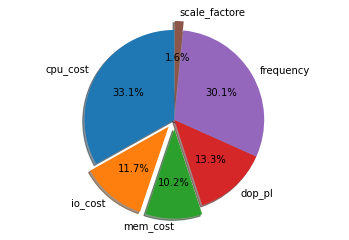

In [109]:
labels = 'cpu_cost', 'io_cost' , 'mem_cost'  ,'dop_pl', 'frequency' , 'scale_factore'
sizes = rf_pl.feature_importances_
explode = (0, 0.1, 0.1, 0 , 0  , 0.1 )  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Evaluation the PBM on the query level

In [110]:
x_test_pl['pred'] = y_pred_pl

In [111]:
x_test_pl

,Q,cpu_cost,io_cost,mem_cost,dop_pl,frequency,db_name,tpc,dop_q,power,pred
12066,Q49,4572100.86,11209336.0,38912.0,5.0,3400000,50,1,5,66.648438,59.971704
5531,Q38,119994.54,26680.0,245756.0,3.0,3400000,30,1,3,65.340500,61.580132
6182,Q6,1499801.12,2935318.0,17824.0,3.0,1900000,50,1,3,44.049316,43.031525
5193,Q33,0.23,8884698.0,102856.0,1.0,2300000,30,1,3,38.192500,30.503537
6772,Q14,14.70,16295084.0,32142.0,1.0,3000000,50,1,3,35.579500,32.375413
...,...,...,...,...,...,...,...,...,...,...,...
9722,Q65,0.15,3212154.0,161514.0,1.0,1200000,10,1,3,28.603500,29.232975
6588,Q11,4556031.99,21960198.0,39182.0,5.0,3000000,50,1,5,52.528353,52.171566
4084,Q37,87499.01,3137751.0,264236.0,3.0,1900000,10,1,3,37.336167,39.031051
9416,Q58,0.25,2174076.0,75008.0,1.0,1900000,10,1,3,28.569000,31.606905


In [112]:
x_train_obm = x_train_pl.groupby(['Q','tpc','dop_q', 'frequency','db_name']).agg({'cpu_cost':'sum','io_cost':'sum','mem_cost':'sum','power':'mean','dop_pl':'sum'})  
x_test_obm = x_test_pl.groupby(['Q','tpc','dop_q', 'frequency','db_name']).agg({'cpu_cost':'sum','io_cost':'sum','mem_cost':'sum','power':'mean','pred':'mean','dop_pl':'sum'})  
x_test_obm

cpu_cost     io_cost  mem_cost      power  \
Q  tpc dop_q frequency db_name                                                
Q1 1   1     800000    10       4120605.58   5913014.0    1568.0  34.175525   
                       50       9473926.61  21525174.0    1120.0  35.338887   
             1200000   30       6577804.30  13444095.0     960.0  35.150032   
                       50       1874751.40   2786059.0     384.0  35.543042   
             1500000   10        375029.70    556748.0     320.0  35.797875   
...                                    ...         ...       ...        ...   
Q9 1   5     2700000   10        375029.70    507590.0   16602.0  54.369000   
                       30          3700.57  15780474.0   48555.0  42.329333   
                       50          3893.54  24125370.0   48555.0  44.091000   
             3400000   30       2754495.66  13840881.0   39498.0  53.944143   
                       50       4556031.99  21656376.0   39179.0  56.187851   

                                     pred  dop_pl  
Q  tpc dop_q frequency db_name                     
Q1 1   1     800000    10       34.778496     2.0  
                       50       35.299735     1.0  
             1200000   30       35.298267     1.0  
                       50       35.616899     1.0  
             1500000   10       35.998090     1.0  
...                                   ...     ...  
Q9 1   5     2700000   10       50.298724     5.0  
                       30       45.731998     5.0  
                       50       46.952316     5.0  
             3400000   30       53.600387     5.0  
                       50       56.816982     5.0  

[3218 rows x 6 columns]

* Evaluation 

In [113]:
mean_absolute_percentage_error(x_test_obm['pred'],x_test_obm['power'])

0.05474974491614085

In [114]:
mean_absolute_error(x_test_obm['pred'],x_test_obm['power'])

2.1507020831755104

* random forst : 0.05484362180302124
* xgboost : 0.06478763937454245
* svm : 0.09298296263809197
* poly : 0.09736727782910812

## OBM with the dop_q and sum dop_pl

In [115]:
x_train_obm

cpu_cost     io_cost  mem_cost      power  \
Q  tpc dop_q frequency db_name                                                
Q1 1   1     800000    30       7702760.10  15115268.0    1568.0  35.304098   
                       50       1874751.40   2785995.0     448.0  35.431708   
             1200000   10       4120605.58   5913238.0    1344.0  34.702811   
                       30       1124955.80   1671397.0     384.0  35.441100   
                       50       9473926.61  21525334.0     960.0  35.256240   
...                                    ...         ...       ...        ...   
Q9 1   5     3000000   30       3883152.03  31177294.0  105143.0  48.899857   
                       50       6434676.93  48392570.0  105462.0  47.353617   
             3400000   10       1332646.87  13785006.0  104071.0  49.376319   
                       30       1128656.37  17331992.0   65645.0  46.534167   
                       50       1878644.94  26727276.0   66283.0  47.074167   

                                dop_pl  
Q  tpc dop_q frequency db_name          
Q1 1   1     800000    30          2.0  
                       50          1.0  
             1200000   10          2.0  
                       30          1.0  
                       50          1.0  
...                                ...  
Q9 1   5     3000000   30         15.0  
                       50         15.0  
             3400000   10         16.0  
                       30         10.0  
                       50         10.0  

[4603 rows x 5 columns]

In [116]:
xobm = x_train_obm[['cpu_cost' , 'io_cost' , 'mem_cost','dop_pl','power']]
xobm['dop_q'] = x_train_obm.index.get_level_values('dop_q').values
xobm['frequency'] = x_train_obm.index.get_level_values('frequency').values
xobm['db_name'] = x_train_obm.index.get_level_values('db_name').values

xobm_test = x_test_obm[['cpu_cost' , 'io_cost' , 'mem_cost','dop_pl','power']]
xobm_test['dop_q'] = x_test_obm.index.get_level_values('dop_q').values
xobm_test['frequency'] = x_test_obm.index.get_level_values('frequency').values
xobm_test['db_name'] = x_test_obm.index.get_level_values('db_name').values
xobm_test

C:\Users\ASUS\AppData\Local\Temp/ipykernel_12976/90160603.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xobm['dop_q'] = x_train_obm.index.get_level_values('dop_q').values
C:\Users\ASUS\AppData\Local\Temp/ipykernel_12976/90160603.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xobm['frequency'] = x_train_obm.index.get_level_values('frequency').values
C:\Users\ASUS\AppData\Local\Temp/ipykernel_12976/90160603.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

cpu_cost     io_cost  mem_cost  dop_pl  \
Q  tpc dop_q frequency db_name                                             
Q1 1   1     800000    10       4120605.58   5913014.0    1568.0     2.0   
                       50       9473926.61  21525174.0    1120.0     1.0   
             1200000   30       6577804.30  13444095.0     960.0     1.0   
                       50       1874751.40   2786059.0     384.0     1.0   
             1500000   10        375029.70    556748.0     320.0     1.0   
...                                    ...         ...       ...     ...   
Q9 1   5     2700000   10        375029.70    507590.0   16602.0     5.0   
                       30          3700.57  15780474.0   48555.0     5.0   
                       50          3893.54  24125370.0   48555.0     5.0   
             3400000   30       2754495.66  13840881.0   39498.0     5.0   
                       50       4556031.99  21656376.0   39179.0     5.0   

                                    power  dop_q  frequency  db_name  
Q  tpc dop_q frequency db_name                                        
Q1 1   1     800000    10       34.175525      1     800000       10  
                       50       35.338887      1     800000       50  
             1200000   30       35.150032      1    1200000       30  
                       50       35.543042      1    1200000       50  
             1500000   10       35.797875      1    1500000       10  
...                                   ...    ...        ...      ...  
Q9 1   5     2700000   10       54.369000      5    2700000       10  
                       30       42.329333      5    2700000       30  
                       50       44.091000      5    2700000       50  
             3400000   30       53.944143      5    3400000       30  
                       50       56.187851      5    3400000       50  

[3218 rows x 8 columns]

In [117]:
scaler_obm = StandardScaler().fit(xobm[['cpu_cost' , 'io_cost' , 'mem_cost' , 'dop_q' , 'frequency' , 'db_name','dop_pl']].values)
x_train_obm_scaled = scaler_obm.transform(xobm[['cpu_cost' , 'io_cost' , 'mem_cost' , 'dop_q' , 'frequency' , 'db_name','dop_pl']].values)
x_test_obm_scaled = scaler_obm.transform(xobm_test[['cpu_cost' , 'io_cost' , 'mem_cost' , 'dop_q' , 'frequency' , 'db_name','dop_pl']].values)

In [118]:
rf_obm = RandomForestRegressor(n_estimators = 100, random_state = 0)
rf_obm.fit(x_train_obm_scaled,xobm['power'].values)

RandomForestRegressor(random_state=0)

In [139]:
rf_obm = XGBRegressor()
rf_obm.fit(x_train_obm_scaled, xobm['power'].values)

[12:50:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [140]:
rf_obm = svm.SVR(kernel = 'linear',  degree=1)
rf_obm.fit(x_train_obm_scaled,xobm['power'].values)

SVR(degree=1, kernel='linear')

In [141]:
rf_obm = LinearRegression()
rf_obm.fit(x_train_obm_scaled,xobm['power'].values)

LinearRegression()

In [119]:
y_pred_obm = rf_obm.predict(x_train_obm_scaled)
mean_absolute_percentage_error(xobm['power'].values,y_pred_obm)

0.0211433842795137

In [120]:
y_pred_obm = rf_obm.predict(x_test_obm_scaled)
mean_absolute_percentage_error(xobm_test['power'].values,y_pred_obm)

0.06405512249834082

In [121]:
mean_absolute_error(xobm_test['power'].values,y_pred_obm)

2.595379135539188

* random forst : 0.06648934381250039
* xgboost : 0.0725868105294451
* svm : 0.1180515645025561
* poly : 0.11755632313131121

Random Forest Regresion features importance

In [122]:
pd.DataFrame(rf_obm.feature_importances_,['cpu_cost', 'io_cost' , 'mem_cost'  ,'dop_q', 'frequency' , 'scale_factore','dop_pl' ],columns=['feature_importances'])

,feature_importances
cpu_cost,0.243513
io_cost,0.098053
mem_cost,0.122202
dop_q,0.086908
frequency,0.375829
scale_factore,0.012495
dop_pl,0.060999


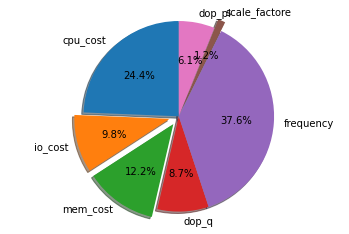

In [123]:
import matplotlib.pyplot as plt

labels = 'cpu_cost', 'io_cost' , 'mem_cost'  ,'dop_q', 'frequency' , 'scale_factore','dop_pl'
sizes = rf_obm.feature_importances_
explode = (0, 0.1, 0.1, 0 , 0  , 0.1 , 0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 

plt.show()

# Conclusion 

from our comparaison we conclued that the **pipeline random forest regresion model**  using the following features (cpu_cost , io_cost , scale factor , mem_cost , dop_pl , frequency ) is the model with the best result :
* MAPE : 0.6211
* MAE : 2.42

generation and saving the model

In [124]:
x_train_pl , x_test_pl  = train_test_split( pl_q[['Q','cpu_cost' , 'io_cost' , 'mem_cost' , 'dop_pl' , 'frequency' , 'db_name','tpc','dop_q','power']] , test_size=0.33 ,random_state = 1)

In [125]:
scaler_pl = StandardScaler().fit(x_train_pl[['cpu_cost' , 'io_cost' , 'mem_cost' , 'dop_pl' , 'frequency' , 'db_name']].values)
x_train_pl_scaled = scaler_pl.transform(x_train_pl[['cpu_cost' , 'io_cost' , 'mem_cost' , 'dop_pl' , 'frequency' , 'db_name']].values)
x_test_pl_scaled = scaler_pl.transform(x_test_pl[['cpu_cost' , 'io_cost' , 'mem_cost' , 'dop_pl' , 'frequency' , 'db_name']].values)

In [126]:
x_train_pl_scaled

array([[-5.70029332e-01,  5.19467709e-01, -5.13939731e-02,
        -9.55103161e-01, -2.41523637e-01,  1.17810378e+00],
       [-2.81705135e-01, -6.42676063e-01,  1.53305802e-02,
        -9.55103161e-01, -1.05762064e+00, -1.25431678e+00],
       [-5.70029397e-01, -1.98469481e-01, -1.05696277e-01,
         1.46141174e+00,  6.91158651e-01,  1.17810378e+00],
       ...,
       [ 1.20643331e+00,  5.21194668e-01, -7.12412199e-02,
         2.53154292e-01, -1.05762064e+00,  1.17810378e+00],
       [-2.23986539e-01, -6.98252512e-01, -1.19725208e-01,
         2.53154292e-01,  2.24817507e-01, -3.81065009e-02],
       [-5.70012421e-01, -8.39205722e-01,  1.71696456e+01,
        -9.55103161e-01, -8.35306498e-03,  1.17810378e+00]])

In [127]:
EnergyCostModel = RandomForestRegressor(n_estimators = 100, random_state = 0)
EnergyCostModel.fit(x_train_pl_scaled,x_train_pl['power'].values)

RandomForestRegressor(random_state=0)

In [128]:
y_pred_pl = EnergyCostModel.predict(x_train_pl_scaled)
mean_absolute_percentage_error(x_train_pl['power'].values,y_pred_pl)

0.024109615424187356

In [129]:
y_pred_pl = EnergyCostModel.predict(x_test_pl_scaled)
mean_absolute_percentage_error(x_test_pl['power'].values,y_pred_pl)

0.062110152636143695

In [130]:
mean_absolute_error(x_test_pl['power'].values,y_pred_pl)

2.426892444041645

In [131]:
pd.DataFrame(EnergyCostModel.feature_importances_,['cpu_cost', 'io_cost' , 'mem_cost'  ,'dop_pl', 'frequency' , 'scale_factore' ],columns=['feature_importances'])

,feature_importances
cpu_cost,0.331424
io_cost,0.116843
mem_cost,0.101889
dop_pl,0.132849
frequency,0.301148
scale_factore,0.015848


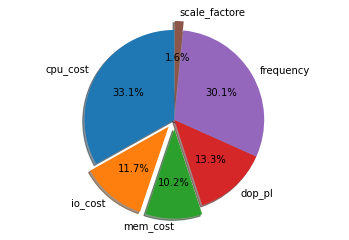

In [132]:
labels = 'cpu_cost', 'io_cost' , 'mem_cost'  ,'dop_pl', 'frequency' , 'scale_factore'
sizes = EnergyCostModel.feature_importances_
explode = (0, 0.1, 0.1, 0 , 0  , 0.1 )  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [133]:
import pickle

pickle.dump(EnergyCostModel, open('EnergyCostModel.pkl', 'wb'))
